<a href="https://colab.research.google.com/github/manny-uncharted/Deep-learning-projects/blob/main/Bruteforce_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unnecessary code dumps

In [ ]:
#@title
!pip install -q kaggle

In [ ]:
#@title Upload kaggle api key
# Import kaggle access key
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manuel14","key":"3b9dfe18c100635bc3acf633996e3786"}'}

In [ ]:
#@title Directory to hold kaggle api-key
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
#@title
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#@title Download Dataset from Kaggle
!kaggle datasets download -d solarmainframe/ids-intrusion-csv

100% 1.60G/1.60G [01:48<00:00, 16.6MB/s]
100% 1.60G/1.60G [01:48<00:00, 15.9MB/s]


In [ ]:
#@title Create Dataset Folder
!mkdir dataset

In [ ]:
#@title Unzip dataset from kaggle into a folder
!unzip ids-intrusion-csv.zip -d dataset

Archive:  ids-intrusion-csv.zip
  inflating: dataset/02-14-2018.csv  
  inflating: dataset/02-15-2018.csv  
  inflating: dataset/02-16-2018.csv  
  inflating: dataset/02-20-2018.csv  
  inflating: dataset/02-21-2018.csv  
  inflating: dataset/02-22-2018.csv  
  inflating: dataset/02-23-2018.csv  
  inflating: dataset/02-28-2018.csv  
  inflating: dataset/03-01-2018.csv  
  inflating: dataset/03-02-2018.csv  


In [ ]:
#@title Save the downloaded dataset from kaggle to google drive
# copy dataset to drive folder
!cp ids-intrusion-csv.zip /content/drive/MyDrive/

# Data Preprocessing

In [ ]:
#@title Loading the dataset from my drive
from google.colab import drive
# drive.mount("/content/drive")
# Fetch zipfile from drive and extract it and store it in a folder called data
!unzip /content/drive/MyDrive/ids-intrusion-csv.zip -d data

Archive:  /content/drive/MyDrive/ids-intrusion-csv.zip
  inflating: data/02-14-2018.csv     
  inflating: data/02-15-2018.csv     
  inflating: data/02-16-2018.csv     
  inflating: data/02-20-2018.csv     
  inflating: data/02-21-2018.csv     
  inflating: data/02-22-2018.csv     
  inflating: data/02-23-2018.csv     
  inflating: data/02-28-2018.csv     
  inflating: data/03-01-2018.csv     
  inflating: data/03-02-2018.csv     


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from IPython.display import Audio

## Understanding the dataset.
The CSE-CIC-IDS2018 dataset contains different classes of types of attack but for our research study we would be focusing on bruteforce attacks.

For the purpose of our study we would be encoding the benign and bruteforce attacks according to the following format.

- 0 - benign
- 1 - Bruteforce attack

In [ ]:
def encode_target(label):
    if label=="Benign":
        return 0 # Benign network traffic
    if "Bruteforce" in label or "BruteForce" in label:
        return 1 # Bruteforce attack

In [ ]:
"""
This function is to clean the dataset and drop missing data and rows with infinity and the target 'Label'.
We are also dropping duplicate network traffic data. We have to drop the timestamp feature as it doesn't give us any relevant information that can help us in our prediction model.
And also the destination port as we just want to predict the attack not the port being attacked.
It also shows the percentage of Mising data and duplicate data
"""
def clean_data(data, time=False):
    data = data.drop("Dst Port", axis = 1)
    
    # Drop any rows with "Infinity" values or labels with the value "Label"
    data = data.drop(data[data.eq("Infinity").any(1)].index,axis=0)
    data = data.drop(data[data.eq("Label").any(1)].index,axis=0)
    
    # Percent of missing data 
    print("Missing Data:",round(data.isnull().sum().sum()/len(data)*100,3),"%") # Just over 0.2%, very minimal so we can remove this 
    data = data.dropna()

    # Percent of duplicated data
    print("Duplicated Data:", round(len(data[data.duplicated()])/len(data)*100,2),"%")
    data = data.drop_duplicates()

    if not time:
        # Dropping the timestamp feature 
        data = data.drop("Timestamp", axis = 1)

    # One hot encoding the protocol feature 
    data['Protocol'] = data['Protocol'].astype(int)
    dum_df = pd.get_dummies(data["Protocol"],prefix="prot_")
    data = data.drop(["Protocol"],axis=1)
    data = pd.concat([data,dum_df],axis=1) 
    
    data["target"] = np.vectorize(encode_target)(data["Label"])
    data = data.drop("Label", axis = 1)

    return data 

In [ ]:
bruteforce = pd.read_csv("/content/data/02-14-2018.csv")

In [ ]:
# Calculating the type of attacks present in the bruteforce dataset.
bruteforce['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [ ]:
# Cleaning our dataset
bruteforce = clean_data(bruteforce,time=False)

Missing Data: 0.217 %
Duplicated Data: 21.65 %


In [ ]:
bruteforce.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,prot__0,prot__6,prot__17,target
0,112641719,3,0,0,0,0,0,0.000000,0.000000,0,...,0,0,56320859.5,139.300036,56320958,56320761,1,0,0,0
1,112641466,3,0,0,0,0,0,0.000000,0.000000,0,...,0,0,56320733.0,114.551299,56320814,56320652,1,0,0,0
2,112638623,3,0,0,0,0,0,0.000000,0.000000,0,...,0,0,56319311.5,301.934596,56319525,56319098,1,0,0,0
3,6453966,15,10,1239,2273,744,0,82.600000,196.741237,976,...,0,0,0.0,0.000000,0,0,0,1,0,0
4,8804066,14,11,1143,2209,744,0,81.642857,203.745545,976,...,0,0,0.0,0.000000,0,0,0,1,0,0


In [ ]:
bruteforce["target"].value_counts()

0    663094
1    156668
Name: target, dtype: int64

In [ ]:
bruteforce.dtypes

Flow Duration      int64
Tot Fwd Pkts       int64
Tot Bwd Pkts       int64
TotLen Fwd Pkts    int64
TotLen Bwd Pkts    int64
                   ...  
Idle Min           int64
prot__0            uint8
prot__6            uint8
prot__17           uint8
target             int64
Length: 80, dtype: object

In [ ]:
bruteforce.describe()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,prot__0,prot__6,prot__17,target
count,8.197620e+05,819762.000000,819762.000000,8.197620e+05,8.197620e+05,819762.000000,819762.000000,819762.000000,819762.000000,819762.000000,...,8.197620e+05,8.197620e+05,8.197620e+05,8.197620e+05,8.197620e+05,8.197620e+05,819762.000000,819762.000000,819762.000000,819762.000000
mean,8.001603e+06,7.654585,8.950084,5.730110e+02,5.783931e+03,223.275652,10.728256,49.610448,64.211154,425.334506,...,1.124240e+05,5.110700e+04,3.966819e+06,9.334026e+05,6.155631e+06,2.720588e+06,0.014493,0.732582,0.252925,0.191114
std,1.425362e+09,50.208779,118.545633,1.779447e+04,1.713250e+05,308.192709,21.452856,55.677538,91.565220,522.013994,...,8.347933e+05,6.332049e+05,6.123993e+08,4.320386e+08,1.721485e+09,2.051077e+07,0.119512,0.442612,0.434688,0.393179
min,-9.190110e+11,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.160000e+02,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,4.915300e+04,2.000000,1.000000,5.600000e+01,1.320000e+02,45.000000,0.000000,40.000000,0.000000,118.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000
75%,1.751970e+06,9.000000,7.000000,1.128000e+03,1.581000e+03,572.000000,22.000000,80.333333,135.847392,976.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,0.000000
max,1.200000e+08,5115.000000,9198.000000,8.591554e+06,1.339773e+07,64440.000000,1460.000000,11217.025225,15760.837590,1460.000000,...,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10,1.000000,1.000000,1.000000,1.000000


In [ ]:
datatypes = bruteforce.dtypes

datatypes

Flow Duration      int64
Tot Fwd Pkts       int64
Tot Bwd Pkts       int64
TotLen Fwd Pkts    int64
TotLen Bwd Pkts    int64
                   ...  
Idle Min           int64
prot__0            uint8
prot__6            uint8
prot__17           uint8
target             int64
Length: 80, dtype: object

In [ ]:
bruteforce_new = bruteforce[np.isfinite(bruteforce).all(1)]

## Visualizing Dataset after cleaning

In [ ]:
# Calculate sum of benign records across partitions
benign_records = bruteforce_new["target"].value_counts()[0]

# Get the number of attack records in each parition after cleaning 
brute_force_attacks = bruteforce_new["target"].value_counts()[1]

org_distribution = pd.DataFrame({"Attack Type":["Benign","Brute-Force"],
                             "Records":[benign_records, brute_force_attacks]})

org_distribution["Percentage"] = round(org_distribution["Records"]/org_distribution["Records"].sum()*100,3)

org_distribution

,Attack Type,Records,Percentage
0,Benign,661847,80.859
1,Brute-Force,156668,19.141


# Handling Data Imbalance

From the above data we can see that the dataset is highly imbalanced and this can affect the results of our training.

For the undersampling dataset we will balance classes by selecting records of each class equal to the number of classes in the class which appears the least. We will also choose a number of benign classes from each day equal to the proportion of total benign classes they represented in the original dataset.

num_ben_in_one_class / total_number_of_benign_classes_in_original_data_set

In [ ]:
bruteforce_sample = bruteforce_new.loc[bruteforce["target"]==1].sample(n=156668).copy()

In [ ]:
bruteforce_benign = bruteforce_new.loc[bruteforce["target"]==0].copy()

In [ ]:
total_benign = len(bruteforce_benign)

In [ ]:
bruteforce_ratio = len(bruteforce_benign)/total_benign

In [ ]:
bruteforce_benign = bruteforce_benign.sample(n = int(bruteforce_ratio*156668))

In [ ]:
# To check if the combination has resulted in the correct number of benign class instances
len(bruteforce_benign)

156668

In [ ]:
benign_sample = pd.concat([bruteforce_benign],axis=0)

### Creating our undersampled dataset

This helps to balance the disparities in the dataset.

In [ ]:
undersampled_dataset = pd.concat([benign_sample,bruteforce_sample],axis=0).sample(frac = 1)

In [ ]:
new_distribtuion = pd.DataFrame({'Attack Type':["Benign","Brute-Force"],
                                 'Records': undersampled_dataset['target'].value_counts().sort_index().values})

new_distribtuion["Percentage"] = round(new_distribtuion["Records"]/new_distribtuion["Records"].sum()*100,3)
new_distribtuion

,Attack Type,Records,Percentage
0,Benign,156668,50.0
1,Brute-Force,156668,50.0


The new dataset now contains a balanced record of both benign and bruteforce attacks

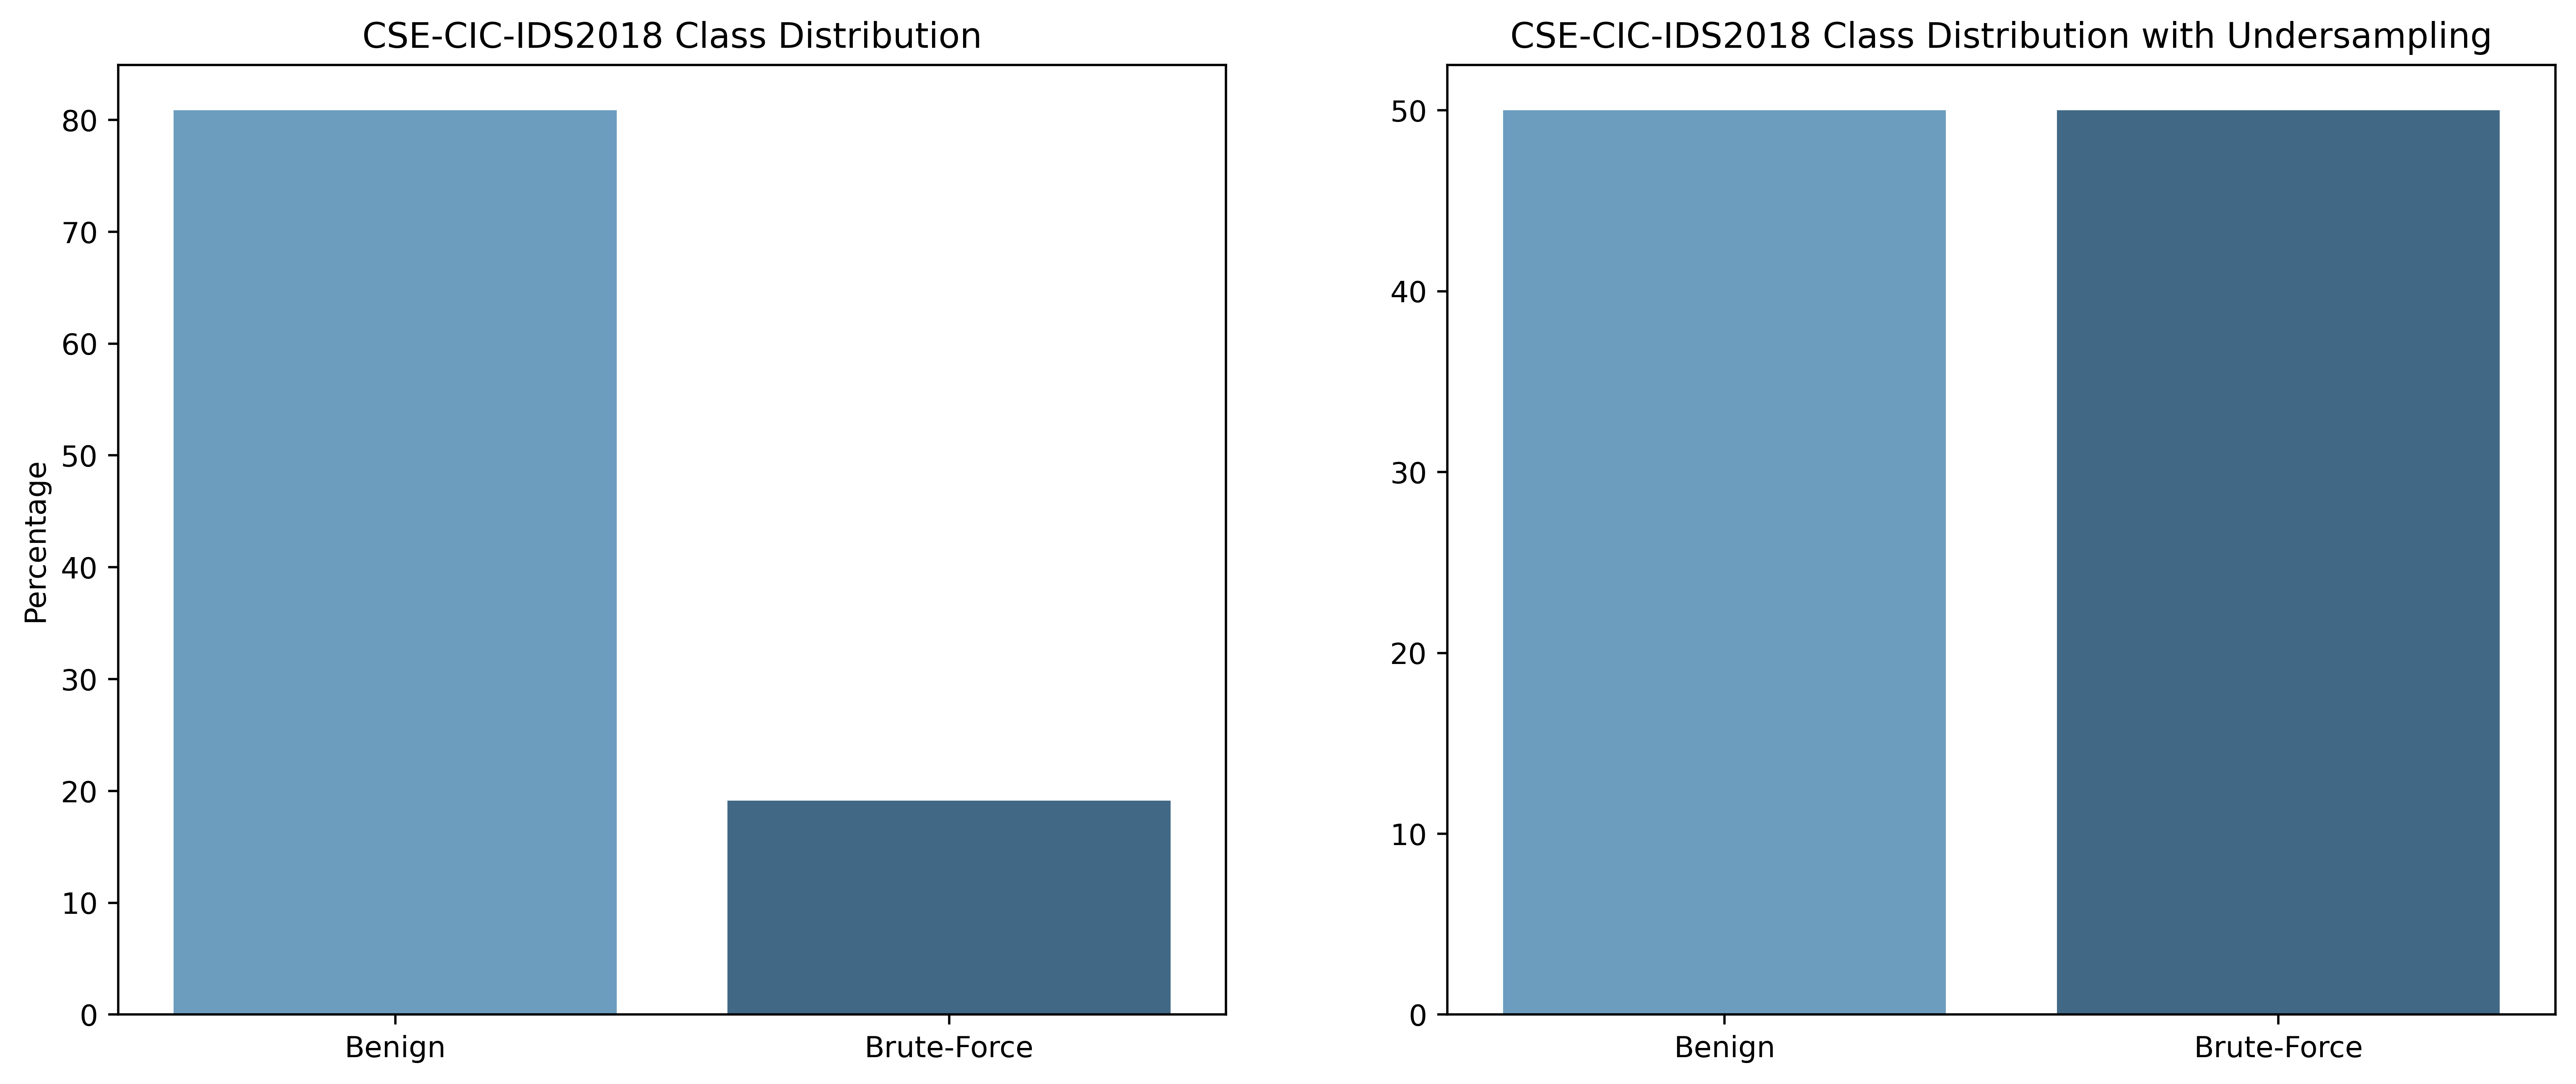

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(15,6),dpi=500)

sns.barplot(x="Attack Type", y = 'Percentage', data = org_distribution, palette='Blues_d', ax=ax[0])
sns.barplot(x="Attack Type", y = 'Percentage', data = new_distribtuion, palette='Blues_d', ax=ax[1])

ax[0].set_title("CSE-CIC-IDS2018 Class Distribution")
ax[1].set_title("CSE-CIC-IDS2018 Class Distribution with Undersampling")
ax[0].set_xlabel("")

ax[1].set_xlabel("")
ax[1].set_ylabel("")
plt.savefig('dist1.png')
plt.show()

In [ ]:
# Creating the new undersampled dataset.
undersampled_dataset.to_csv("/content/data/undersampled_cic.csv", index=False)

In [ ]:
# Loading the new dataset
data = pd.read_csv("/content/data/undersampled_cic.csv")
cic_X = data.drop("target",axis=1).values
cic_y = data["target"].values

print(cic_X.shape[0], 'records',cic_X.shape[1],'features')

313336 records 79 features


# Model Building

In [ ]:
#@title Creating the Models we need
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import svm 

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten, SimpleRNN, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import plot_model
from keras.layers import CuDNNLSTM

from timeit import timeit

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
#@title SVM model
class SVM:
    def __init__(self, X, y, split, ae= False, ae_dim =0, ae_train_perc = 0.25):
        self.split = split 
        self.ae = ae 
        self.ae_dim = ae_dim
        self.ae_train_perc = ae_train_perc
        
        # For CSE-CIC-IDS2018 
        if self.split:
            self.X = X 
            self.y = y
        else: 
            self.X_train, self.X_test = X
            self.y_train, self.y_test = y 
            
    def preprocess_data(self):
        
        if self.split:
            # Split data into train and test split 
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, stratify = self.y)
        else:
            X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)
        X_test = min_max_scaler.transform(X_test)
        
        if self.ae: 
            _ , X_val = train_test_split(X_train, test_size=self.ae_train_perc, random_state=42)
            
            encoder = Sequential()
            encoder.add(Dense(self.ae_dim, activation='relu',input_shape=[X_val.shape[1]]))

            decoder = Sequential()
            decoder.add(Dense(X_val.shape[1], activation='relu', input_shape=[self.ae_dim], activity_regularizer=regularizers.l1(0.2))) # sparsity parameter

            autoencoder = Sequential([encoder,decoder])
            autoencoder.compile(loss='mse',optimizer = 'adam')

            early_stop = EarlyStopping(monitor='loss', mode = 'auto', 
                                       patience = 5 , verbose =0, restore_best_weights=True)

            autoencoder.fit(X_val, X_val, epochs=40, batch_size=256,verbose=0, callbacks=[early_stop])

            X_train = encoder.predict(X_train)
            X_test = encoder.predict(X_test)
        
        return X_train, X_test, y_train, y_test
        
    def evaluate(self, runs):
        results = pd.DataFrame(columns=["acc","prec","rec","f1","far"])
        reports = []    
        
        for i in range(runs):
            X_train, X_test, y_train, y_test = self.preprocess_data()

            model = svm.SVC()
            model.fit(X_train,y_train)

            y_pred = model.predict(X_test)

            acc = metrics.accuracy_score(y_test,y_pred)
            prec = metrics.precision_score(y_test,y_pred,average='weighted')
            rec = metrics.recall_score(y_test,y_pred,average='weighted')
            f1 = metrics.f1_score(y_test,y_pred,average='weighted')
            
            confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
            FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
            FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
            TP = np.diag(confusion_matrix)
            TN = confusion_matrix.sum() - (FP + FN + TP)
            FAR = FP/(FP+TN)
            
            model_results = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1,'far':FAR.mean()}
            results = results.append(model_results, ignore_index= True)
            print(f"Model {i} Acc:", acc)
            
            report = pd.DataFrame(metrics.classification_report(y_test,y_pred,output_dict=True)).transpose()
            reports.append(report)
            
        self.acc = results.mean()[0], results.std()[0]
        self.prec = results.mean()[1], results.std()[1]
        self.rec = results.mean()[2], results.std()[2]
        self.f1 = results.mean()[3], results.std()[3]
        self.far = results.mean()[4], results.std()[4]
        self.report = pd.concat(reports).groupby(level=0).mean()  

In [ ]:
#@title Deep Neural Network
class DNN:
    def __init__(self, X, y, split, ae= False, ae_dim =0 , ae_train_perc = 0.25):
        self.split = split 
        self.ae = ae 
        self.ae_dim = ae_dim
        self.ae_train_perc = ae_train_perc
        
        # For CSE-CIC-IDS2018 
        if self.split:
            self.X = X 
            self.y = y
        else: 
            self.X_train, self.X_test = X
            self.y_train, self.y_test = y 
            
        
    def preprocess_data(self):
        if self.split:
            # Split data into train and test split 
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, stratify = self.y)
        else:
            X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
            
        # Scale Data 
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)
        X_test = min_max_scaler.transform(X_test)
        
        # Encode Labels
        y_train = pd.get_dummies(y_train).values
        y_test = pd.get_dummies(y_test).values
        
        # Use Auto Encoder to perform dimensionality reduction 
        if self.ae: 
            _ , X_val = train_test_split(X_train, test_size=self.ae_train_perc, random_state=42)
            
            encoder = Sequential()
            encoder.add(Dense(self.ae_dim, activation='relu',input_shape=[X_val.shape[1]]))

            decoder = Sequential()
            decoder.add(Dense(X_val.shape[1], activation='relu', input_shape=[self.ae_dim]))

            autoencoder = Sequential([encoder,decoder])
            autoencoder.compile(loss='mse',optimizer = 'adam')

            early_stop = EarlyStopping(monitor='loss', mode = 'auto', 
                                       patience = 5 , verbose =0, restore_best_weights=True)

            autoencoder.fit(X_val, X_val, epochs=40, batch_size=256,verbose=0, callbacks=[early_stop])

            X_train = encoder.predict(X_train)
            X_test = encoder.predict(X_test)
        
        return X_train, y_train, X_test, y_test
        
    def build_model(self, hidden_layers):
        
        # Split data into training and testing set, scale it and encode labels 
        X_train, y_train, X_test, y_test = self.preprocess_data()
        
        # Further divide Data into training and validation data
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        model = Sequential()
        
        for layer in hidden_layers:
            model.add(Dense(layer, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))

        model.add(Dense(y_train.shape[1], activation = 'softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        
        early_stop = EarlyStopping(monitor='val_loss', mode = 'auto', 
                                   patience = 5 , verbose =0, restore_best_weights=True)
        
        model.fit(x = X_train, y = y_train, epochs = 200, batch_size = 256, verbose = 0,
                   validation_data = (X_val,y_val),callbacks = [early_stop])
        
        return model, X_test, y_test
    
    def evaluate_model(self, runs, hidden_layers, time=False):
        results = pd.DataFrame(columns=["acc","prec","rec","f1","far","Train Time","Test Time"])
        reports = []
        
        # Train and evaluate model 
        for i in range(runs):
            print(f"Training Model {i} ...")
            
            if time:
                training_time = timeit(lambda: self.build_model(hidden_layers), number = 1)
            else:
                training_time= np.nan
                
            model, X_test, y_test = self.build_model(hidden_layers)
            
            print(f"Evaluating Model {i} ...")
            if time:
                testing_time = timeit(lambda: model.predict(X_test), number = 1)
            else:
                testing_time = np.nan
      
            y_pred = np.argmax(model.predict(X_test), axis=-1)
            y_org = np.argmax(y_test,axis=1)
            
            acc = metrics.accuracy_score(y_org,y_pred)
            prec = metrics.precision_score(y_org,y_pred,average='weighted')
            rec = metrics.recall_score(y_org,y_pred,average='weighted')
            f1 = metrics.f1_score(y_org,y_pred,average='weighted')
            
            confusion_matrix = metrics.confusion_matrix(y_org,y_pred)
            FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
            FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
            TP = np.diag(confusion_matrix)
            TN = confusion_matrix.sum() - (FP + FN + TP)
            FAR = FP/(FP+TN)
            
            model_results = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1,'far':FAR.mean(),
                             'Train Time':training_time,'Test Time':testing_time}
            results = results.append(model_results, ignore_index= True)
            print(f"Model {i} Acc:", acc)
            
            # Creation of a classification report which is useful for examining per class metrics
            report = pd.DataFrame(metrics.classification_report(y_org,y_pred,output_dict=True)).transpose()
            reports.append(report)
        
        self.acc = results.mean()[0], results.std()[0]
        self.prec = results.mean()[1], results.std()[1]
        self.rec = results.mean()[2], results.std()[2]
        self.f1 = results.mean()[3], results.std()[3]
        self.far = results.mean()[4], results.std()[4]
        self.train_time = results.mean()[5], results.std()[5]
        self.test_time = results.mean()[6], results.std()[6]
        self.report = pd.concat(reports).groupby(level=0).mean()

In [ ]:
#@title Convoluted Neural Network Model
class CNN:
    def __init__(self, X, y, split, image_dim, ae= False, ae_dim =0, ae_train_perc = 0.25):
        self.split = split 
        self.ae = ae 
        self.ae_dim = ae_dim
        self.image_dim = image_dim
        self.ae_train_perc = ae_train_perc
        
        # For CSE-CIC-IDS2018 
        if self.split:
            # Add two extra features for 2D image inputs 
            a = np.zeros((len(X),1))
            b = np.zeros((len(X),1))
            self.X = np.hstack((X,a,b))
            self.y = y
        else: 
            self.X_train, self.X_test = X
            self.y_train, self.y_test = y 
            
    def preprocess_data(self):
        
        if self.split:
            # Split data into train and test split 
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, stratify = self.y)
        else:
            X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test

        # Scale Data 
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)
        X_test = min_max_scaler.transform(X_test)

        # Encode Labels
        y_train = pd.get_dummies(y_train).values
        y_test = pd.get_dummies(y_test).values

        # Use Auto Encoder to perform dimensionality reduction 
        if self.ae: 
            _ , X_val = train_test_split(X_train, test_size=self.ae_train_perc, random_state=42)
            
            encoder = Sequential()
            encoder.add(Dense(self.ae_dim, activation='relu',input_shape=[X_val.shape[1]]))

            decoder = Sequential()
            decoder.add(Dense(X_val.shape[1], activation='relu', input_shape=[self.ae_dim]))

            autoencoder = Sequential([encoder,decoder])
            autoencoder.compile(loss='mse',optimizer = 'adam')

            early_stop = EarlyStopping(monitor='loss', mode = 'auto', 
                                       patience = 5 , verbose =0, restore_best_weights=True)

            autoencoder.fit(X_val, X_val, epochs=40, batch_size=256,verbose=0, callbacks=[early_stop])

            X_train = encoder.predict(X_train)
            X_test = encoder.predict(X_test)

        # Reshape the data into 2D input arrays
        X_train = X_train.reshape(len(X_train), self.image_dim, self.image_dim,1)
        X_test = X_test.reshape(len(X_test), self.image_dim, self.image_dim,1) 

        return X_train, y_train, X_test, y_test
        
    def display_class_image(self, classes):
        X_train, y_train, X_test, y_test = self.preprocess_data()
        y_train_ser = pd.Series(np.argmax(y_train,axis=1))
        fig, axs = plt.subplots(nrows =1 , ncols = (len(classes)), figsize= (15,6))
        for c in classes.keys():
            X_image = X_train[y_train_ser[y_train_ser==c].index[0]]
            axs[c].imshow(X_image[:,:,0], cmap='gray')
            axs[c].set_title(classes[c])
            axs[c].axis('off')
        plt.show()
        
    def build_model(self):
        
        # Split data into training and testing set, scale it and encode labels 
        X_train, y_train, X_test, y_test = self.preprocess_data()
    
        # Further divide Data into training and validation data
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify= y_train)

        model = Sequential()

        model.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(self.image_dim,self.image_dim,1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPool2D(pool_size=(2, 2)))

        
        model.add(Conv2D(filters=16, kernel_size=(2,2), padding = 'same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.2))
        
        model.add(Dense(y_train.shape[1],activation = "softmax"))

        model.compile(loss="categorical_crossentropy", optimizer = 'adam')
        
        early_stop = EarlyStopping(monitor='val_loss', mode = 'auto', 
                                   patience = 5 , verbose = 0, restore_best_weights=True)
        
        model.fit(x = X_train, y = y_train, epochs = 100, batch_size = 256, verbose = 0, 
                  callbacks = [early_stop], validation_data = (X_val,y_val))
        
        return model, X_test, y_test
        
 
    def evaluate_model(self, runs, time=False):
        results = pd.DataFrame(columns=["acc","prec","rec","f1","far","Train Time","Test Time"])
        reports = []
        
        # Train and evaluate model 
        for i in range(runs):
            
            print(f"Training Model {i} ...")
            
            if time:
                training_time = timeit(lambda: self.build_model(), number = 1)
            else:   
                training_time= np.nan 
            model, X_test, y_test = self.build_model()
            
            print(f"Evaluating Model {i} ...")
            
            if time:
                  testing_time = timeit(lambda: model.predict(X_test), number = 1)
            else:        
                testing_time = np.nan
                
            y_pred = np.argmax(model.predict(X_test), axis=-1)
            y_org = np.argmax(y_test,axis=1)
            
            acc = metrics.accuracy_score(y_org,y_pred)
            prec = metrics.precision_score(y_org,y_pred,average='weighted')
            rec = metrics.recall_score(y_org,y_pred,average='weighted')
            f1 = metrics.f1_score(y_org,y_pred,average='weighted')
            
            confusion_matrix = metrics.confusion_matrix(y_org,y_pred)
            FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
            FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
            TP = np.diag(confusion_matrix)
            TN = confusion_matrix.sum() - (FP + FN + TP)
            FAR = FP/(FP+TN)
            
            model_results = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1,'far':FAR.mean(),
                             'Train Time':training_time,'Test Time':testing_time}
            results = results.append(model_results, ignore_index= True)
            print(f"Model {i} Acc:", acc)
            
            # Creation of a classification report which is useful for examining per class metrics
            report = pd.DataFrame(metrics.classification_report(y_org,y_pred,output_dict=True)).transpose()
            reports.append(report)
        
        self.acc = results.mean()[0], results.std()[0]
        self.prec = results.mean()[1], results.std()[1]
        self.rec = results.mean()[2], results.std()[2]
        self.f1 = results.mean()[3], results.std()[3]
        self.far = results.mean()[4], results.std()[4]
        self.train_time = results.mean()[5], results.std()[5]
        self.test_time = results.mean()[6], results.std()[6]
        self.report = pd.concat(reports).groupby(level=0).mean()

In [ ]:
#@title LSTM model
class RNN_LSTM:
    def __init__(self, X, y, split, num_of_classes, ae= False, ae_dim =0, ae_train_perc = 0.25):
        self.split = split 
        self.ae = ae 
        self.ae_dim = ae_dim
        self.num_of_classes = num_of_classes
        self.ae_train_perc = ae_train_perc
        
        # For CSE-CIC-IDS2018 
        if self.split:
            # Add two extra features for 2D image inputs 
            a = np.zeros((len(X),1))
            b = np.zeros((len(X),1))
            self.X = np.hstack((X,a,b))
            self.y = y
        else: 
            self.X_train, self.X_test = X
            self.y_train, self.y_test = y 
            
    def preprocess_data(self):
        
        if self.split:
            # Split data into train and test split 
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, stratify = self.y)
        else:
            X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test

        # Scale Data 
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)
        X_test = min_max_scaler.transform(X_test)

        # Use Auto Encoder to perform dimensionality reduction 
        if self.ae: 
            _ , X_val = train_test_split(X_train, test_size=self.ae_train_perc, random_state=42)
            
            encoder = Sequential()
            encoder.add(Dense(self.ae_dim, activation='relu',input_shape=[X_val.shape[1]]))

            decoder = Sequential()
            decoder.add(Dense(X_val.shape[1], activation='relu', input_shape=[self.ae_dim]))

            autoencoder = Sequential([encoder,decoder])
            autoencoder.compile(loss='mse',optimizer = 'adam')

            early_stop = EarlyStopping(monitor='loss', mode = 'auto', 
                                       patience = 5 , verbose =0, restore_best_weights=True)

            autoencoder.fit(X_val, X_val, epochs=40, batch_size=256,verbose=0, callbacks=[early_stop])

            X_train = encoder.predict(X_train)
            X_test = encoder.predict(X_test)

        # Reshape the data into 3D input arrays which include a time dimension as input for LSTM
        X_train = X_train.reshape(len(X_train), 1, X_train.shape[1])
        X_test = X_test.reshape(len(X_test), 1, X_test.shape[1]) 

        return X_train, y_train, X_test, y_test
      
        
    def build_model(self):
        # Split data into training and testing set, scale it and encode labels 
        X_train, y_train, X_test, y_test = self.preprocess_data()
        
        # Further divide Data into training and validation data
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify= y_train)
        
        input_dim = X_train.shape[1]
        model = Sequential()

        model.add(LSTM(64, input_shape = (1,X_train.shape[2]), return_sequences=True, unroll=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))


        model.add(LSTM(32,unroll=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))


        model.add(Dense(self.num_of_classes, activation ='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

        early_stop = EarlyStopping(monitor='val_loss', mode = 'auto', 
                           patience = 5 , verbose =1, restore_best_weights=True)

        model.fit(x = X_train, y = y_train, epochs = 100, batch_size = 256, verbose = 0,
                  callbacks = [early_stop], validation_data = (X_val,y_val))
        
        return model, X_test, y_test
    
    def evaluate_model(self, runs,time=False):
        results = pd.DataFrame(columns=["acc","prec","rec","f1","far","Train Time","Test Time"])
        reports = []
        
        self.preprocess_data()
        
        for i in range(runs):
            print(f"Training Model {i} ...")
            if time:
                training_time = timeit(lambda: self.build_model(), number = 1)
            else:
                training_time= np.nan
                
            model, X_test, y_test = self.build_model()
            print(f"Evaluating Model {i} ...")
            
            if time:
                testing_time = timeit(lambda: model.predict(X_test), number = 1)
            else:
                testing_time=1
                
            y_pred = np.argmax(model.predict(X_test), axis=-1)
            
            acc = metrics.accuracy_score(y_test,y_pred)
            prec = metrics.precision_score(y_test,y_pred,average='weighted')
            rec = metrics.recall_score(y_test,y_pred,average='weighted')
            f1 = metrics.f1_score(y_test,y_pred,average='weighted')
            
            confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
            FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
            FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
            TP = np.diag(confusion_matrix)
            TN = confusion_matrix.sum() - (FP + FN + TP)
            FAR = FP/(FP+TN)
            
            model_results = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1,'far':FAR.mean(),
                             'Train Time':training_time,'Test Time':testing_time}
            results = results.append(model_results, ignore_index= True)
            print(f"Model {i} Acc:", acc)
            
            # Creation of a classification report which is useful for examining per class metrics
            report = pd.DataFrame(metrics.classification_report(y_test,y_pred,output_dict=True)).transpose()
            reports.append(report)
        
        self.acc = results.mean()[0], results.std()[0]
        self.prec = results.mean()[1], results.std()[1]
        self.rec = results.mean()[2], results.std()[2]
        self.f1 = results.mean()[3], results.std()[3]
        self.far = results.mean()[4], results.std()[4]
        self.train_time = results.mean()[5], results.std()[5]
        self.test_time = results.mean()[6], results.std()[6]
        self.report = pd.concat(reports).groupby(level=0).mean()

In [ ]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics 

## Creating our baseline evaluation. 

Based on previous evaluation using standard machine learning results as a comparison for our own results.

We would be using the results from SVM(Support Vector Machines) models

In [ ]:
cic_svm = SVM(cic_X,cic_y,split=True)
cic_svm.evaluate(10)

Model 0 Acc: 0.9991276688545867
Model 1 Acc: 0.9989680960840842
Model 2 Acc: 0.9993829852873906
Model 3 Acc: 0.9991276688545867
Model 4 Acc: 0.9990957543004861
Model 5 Acc: 0.9990744779310858
Model 6 Acc: 0.9990638397463857
Model 7 Acc: 0.9991170306698864
Model 8 Acc: 0.9990106488228848
Model 9 Acc: 0.99934043254859


In [ ]:
# Deep Neural Network results

cic_dnn = DNN(X = cic_X, y = cic_y, split = True)
cic_dnn.evaluate_model(5,[64,32,16], time=True)

Training Model 0 ...
Evaluating Model 0 ...
2938/2938 [==============================] - 5s 2ms/step
Model 0 Acc: 0.9999787236305997
Training Model 1 ...
Evaluating Model 1 ...
2938/2938 [==============================] - 5s 2ms/step
Model 1 Acc: 0.9998404272294975
Training Model 2 ...
Evaluating Model 2 ...
2938/2938 [==============================] - 5s 2ms/step
Model 2 Acc: 0.9999574472611994
Training Model 3 ...
Evaluating Model 3 ...
2938/2938 [==============================] - 5s 2ms/step
Model 3 Acc: 0.9999255327070988
Training Model 4 ...
Evaluating Model 4 ...
2938/2938 [==============================] - 5s 2ms/step
Model 4 Acc: 0.9999680854458995


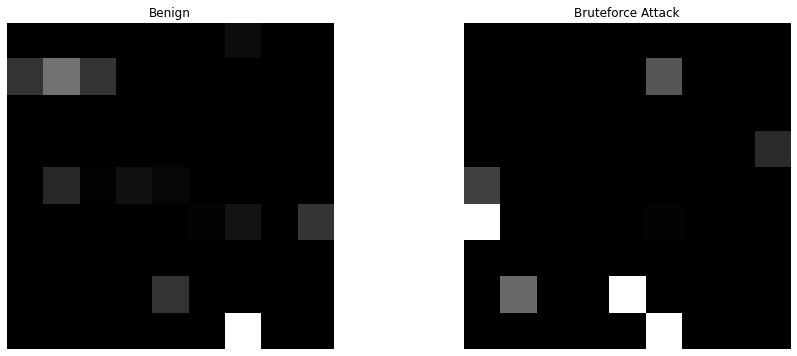

In [ ]:
# Convolutional Neural Network results
cic_cnn = CNN(X = cic_X, y = cic_y, split=True, image_dim=9) # 81 Features = 9x9 Images
cic_cnn.display_class_image({0:'Benign', 1:'Bruteforce Attack'})

In [ ]:
cic_cnn.evaluate_model(5,time=True)

Training Model 0 ...
Evaluating Model 0 ...
2938/2938 [==============================] - 5s 2ms/step
Model 0 Acc: 0.9999680854458995
Training Model 1 ...
Evaluating Model 1 ...
2938/2938 [==============================] - 5s 2ms/step
Model 1 Acc: 0.9999787236305997
Training Model 2 ...
Evaluating Model 2 ...
2938/2938 [==============================] - 5s 2ms/step
Model 2 Acc: 0.9999680854458995
Training Model 3 ...
Evaluating Model 3 ...
2938/2938 [==============================] - 5s 2ms/step
Model 3 Acc: 0.9999468090764991
Training Model 4 ...
Evaluating Model 4 ...
2938/2938 [==============================] - 5s 2ms/step
Model 4 Acc: 0.9999148945223987


In [ ]:
# LSTM results
cic_lstm = RNN_LSTM(X=cic_X, y = cic_y, split = True, num_of_classes=7)

In [ ]:
cic_lstm.evaluate_model(5, time=True)

Training Model 0 ...


Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping


Restoring model weights from the end of the best epoch: 12.
Epoch 17: early stopping
Evaluating Model 0 ...
2938/2938 [==============================] - 5s 2ms/step
Model 0 Acc: 0.9999680854458995
Training Model 1 ...


Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
Evaluating Model 1 ...
2938/2938 [==============================] - 6s 2ms/step
Model 1 Acc: 0.9998723417835981
Training Model 2 ...


Restoring model weights from the end of the best epoch: 25.
Epoch 30: early stopping


Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Evaluating Model 2 ...
2938/2938 [==============================] - 6s 2ms/step
Model 2 Acc: 0.9999042563376985
Training Model 3 ...


Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping


Restoring model weights from the end of the best epoch: 19.
Epoch 24: early stopping
Evaluating Model 3 ...
2938/2938 [==============================] - 5s 2ms/step
Model 3 Acc: 0.9999468090764991
Training Model 4 ...


Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping


Restoring model weights from the end of the best epoch: 16.
Epoch 21: early stopping
Evaluating Model 4 ...
2938/2938 [==============================] - 5s 2ms/step
Model 4 Acc: 0.9999680854458995


## Model Results Comparison


In [ ]:
def autolabel(rects, xpos='center', perc=True):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        if perc:
            ax.annotate('{}%'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos]*3, 1),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom',
                        fontsize = 11)
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos]*3, 1),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom',
                        fontsize = 11)

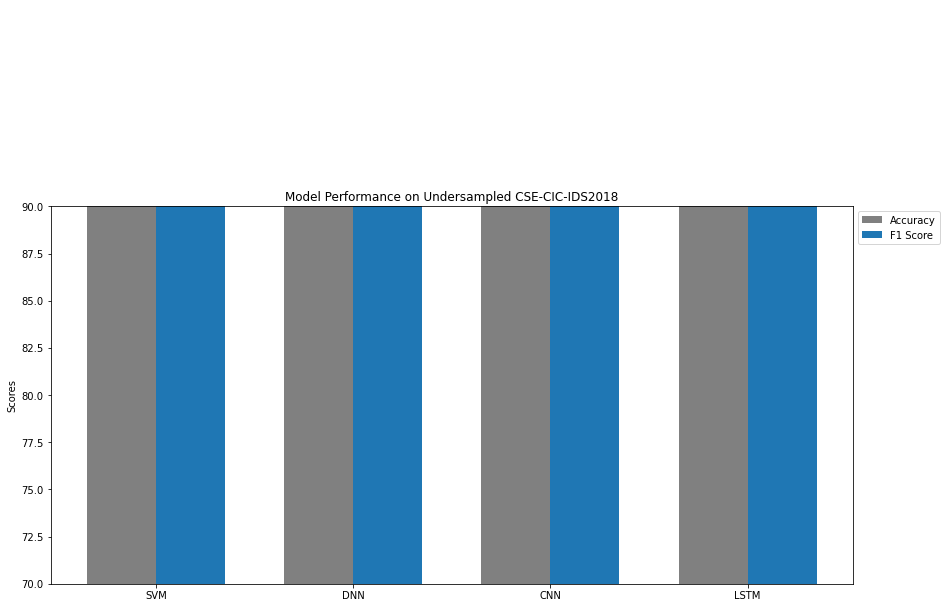

In [ ]:
cic_acc_means, cic_acc_std = (round(cic_svm.acc[0]*100,3),round(cic_dnn.acc[0]*100,3), round(cic_cnn.acc[0]*100,3), round(cic_lstm.acc[0]*100,3)), \
                     (cic_svm.acc[1]*100,cic_dnn.acc[1]*100, cic_cnn.acc[1]*100, cic_lstm.acc[1]*100)
    
cic_f1_means, cic_f1_std = (round(cic_svm.f1[0]*100,3), round(cic_dnn.f1[0]*100,3), round(cic_cnn.f1[0]*100,3), round(cic_lstm.f1[0]*100,3)), \
                         (cic_svm.f1[1]*100, cic_dnn.f1[1]*100, cic_cnn.f1[1]*100, cic_lstm.f1[1]*100)
    
ind = np.arange(len(cic_acc_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind - width/2, cic_acc_means, width, yerr=cic_acc_std,
                label='Accuracy', color='grey')
rects2 = ax.bar(ind + width/2, cic_f1_means, width, yerr=cic_f1_std,
                label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance on Undersampled CSE-CIC-IDS2018')
ax.set_xticks(ind)
ax.set_xticklabels(('SVM','DNN', 'CNN', 'LSTM'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()
plt.ylim(70,90)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("acc_f1_cic.pdf")
plt.show()

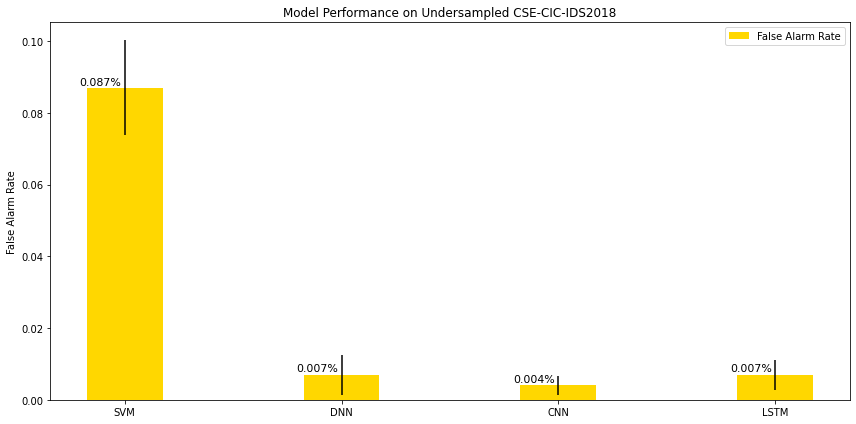

In [ ]:
cic_far_means, cic_far_std = (round(cic_svm.far[0]*100,3),round(cic_dnn.far[0]*100,3), round(cic_cnn.far[0]*100,3), round(cic_lstm.far[0]*100,3)), \
                     (cic_svm.far[1]*100, cic_dnn.far[1]*100, cic_cnn.far[1]*100, cic_lstm.far[1]*100)

    
ind = np.arange(len(cic_far_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, cic_far_means, width, yerr=cic_far_std,
                label='False Alarm Rate', color='gold')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('False Alarm Rate')
ax.set_title('Model Performance on Undersampled CSE-CIC-IDS2018')
ax.set_xticks(ind)
ax.set_xticklabels(('SVM','DNN', 'CNN', 'LSTM'))
ax.legend()

autolabel(rects1, "left")
fig.tight_layout()

#plt.ylim(70,90)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("far_cic.pdf")
plt.show()

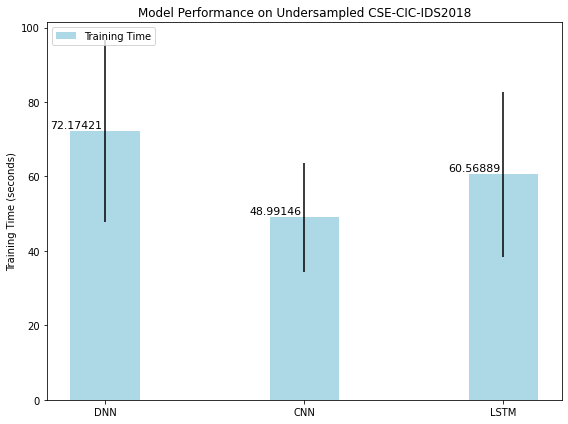

In [ ]:
train_time_means, train_time_std = (round(cic_dnn.train_time[0],5), round(cic_cnn.train_time[0],5), round(cic_lstm.train_time[0],5)), \
                     (cic_dnn.train_time[1], cic_cnn.train_time[1], cic_lstm.train_time[1])

    
ind = np.arange(len(train_time_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, train_time_means, width, yerr=train_time_std,
                label='Training Time', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Model Performance on Undersampled CSE-CIC-IDS2018')
ax.set_xticks(ind)
ax.set_xticklabels(('DNN', 'CNN', 'LSTM'))
ax.legend()

autolabel(rects1, "left",perc=False)
fig.tight_layout()

#plt.ylim(70,90)
plt.legend(loc=2)
#plt.xlabel("Model")
plt.savefig("train_time_cic.pdf")

plt.show()

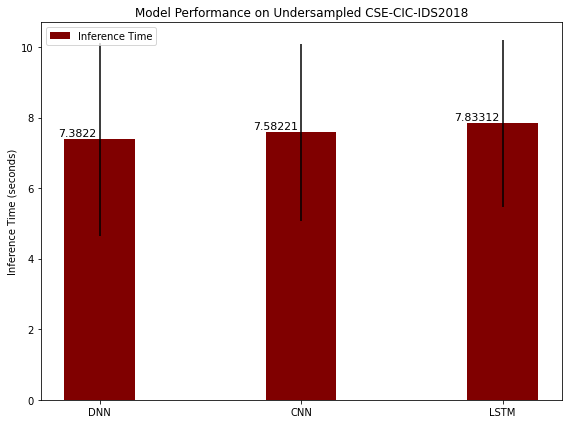

In [ ]:
test_time_means, test_time_std = (round(cic_dnn.test_time[0],5), round(cic_cnn.test_time[0],5), round(cic_lstm.test_time[0],5)), \
                     (cic_dnn.test_time[1], cic_cnn.test_time[1], cic_lstm.test_time[1])

    
ind = np.arange(len(test_time_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, test_time_means, width, yerr=test_time_std,
                label='Inference Time', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference Time (seconds)')
ax.set_title('Model Performance on Undersampled CSE-CIC-IDS2018')
ax.set_xticks(ind)
ax.set_xticklabels(('DNN', 'CNN', 'LSTM'))
ax.legend()

autolabel(rects1, "left",perc=False)
fig.tight_layout()

#plt.ylim(70,90)
plt.legend(loc=2)
#plt.xlabel("Model")
plt.savefig("test_time_cic.pdf")

plt.show()